Fully convolutional neural networks are mostly used for image segmentation and are handy since they can be used with a variety of input shapes (whereas neural networks with fully connected layers require a specified input shape).
<br>
However, convolutional neural networks can also be used for e.g. biological sequences. We'll try to make a FCN that predicts dihedral angles in proteins from their sequences. We'll then use the tool PeptideBuilder (https://github.com/clauswilke/PeptideBuilder/blob/master/tests/test_PeptideBuilder.py) to build 3D structures from the angles.
<br>
<br>
The data is from https://github.com/aqlaboratory/proteinnet casp7. My computational resources are limited so I won't necessarily use all the training data. Data was preprocessed in https://github.com/githubz0r/random/blob/master/protein_fcn_preproc.ipynb 
<br>
<br>
In order to circumvent the fact that angles don't work well with MSE loss, we transform them into sin/cos and then transform the predictions back to angles using arctan2.
<br>

The proteins are encoded as $N*C*L$ where $C$ = 20 (number of amino acids) and $L$ = length.

In [1]:
import numpy as np
import torch
import imp
import re
import matplotlib.pyplot as plt
import pickle
import PeptideBuilder

We make a helper function to get the dihedral angles from sin and cos (which are used instead of the angles themselves because we used the mean squared error loss function) using arctan2.

In [2]:
def back_to_angle(sin_cos_array, n_angles=3):
    angles = []
    for i in range(n_angles):
        angles_i = np.arctan2(sin_cos_array[:, i, :], sin_cos_array[:, n_angles+i, :])
        # remember that we input sin first due to atan2 definition
        angles_i = angles_i[:, np.newaxis, :]
        angles.append(angles_i)
    angles_arr = np.concatenate(angles, 1)
    return(angles_arr)
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}
pos_aa_dict = {j:i for i,j in aa_id_dict.items()}

Load files.

In [3]:
train_file = open('protein_fcn_data_test/train_data_proc', 'rb')
train_data = pickle.load(train_file)
train_file.close()

In [4]:
val_file = open('protein_fcn_data_test/val_data_proc', 'rb')
val_data = pickle.load(val_file)
val_file.close()

In [5]:
train_seqs = train_data['train_seqs']
train_coords = train_data['train_coords']
train_angles_sin_cos = train_data['train_angles_sin_cos']
train_angles = [back_to_angle(i.numpy()) for i in train_angles_sin_cos]
train_ids_remain = train_data['train_ids_after_filt']

In [6]:
val_seqs = val_data['val_seqs']
val_coords = val_data['val_coords']
val_angles_sin_cos = val_data['val_angles_sin_cos']
val_angles = [back_to_angle(i.numpy()) for i in val_angles_sin_cos]
val_ids_remain = val_data['val_ids_after_filt']

We can check how many proteins there are.

In [7]:
print(len(train_seqs))
print(len(val_seqs))

7964
184


We write a dataset class for the torch DataLoader. Since we only want to pad the minibatches to the same size (instead of putting everything in one big tensor, since this gives a worse performance), we also need a custom collate function to deal with this.

In [8]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, angles):
        self.sequences = seqs
        self.angles = angles

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.angles[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    angles = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        angles_padded = np.pad(angles[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded)
        angles[i] = torch.tensor(angles_padded)
    seq_tensor = torch.cat(seqs, 0)
    angle_tensor = torch.cat(angles, 0)
    return([seq_tensor, angle_tensor])
    

In [9]:
train_dataset = proteindataset(train_seqs, train_angles_sin_cos)
val_dataset = proteindataset(val_seqs, val_angles_sin_cos)

In [10]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2, collate_fn=protein_collate)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, # we don't need testing yet
                                         #shuffle=False, num_workers=2)

Define and train the neural network.
<br>
First half of the network does convolution and the second half does up-convolution. It also has some skip connections, inspired by the U-NET architecture for image segmentation. The parameters, i.e. number of kernels and the various dimensions were chosen more or less arbitrarily, since the main intention with this script is showing how it can be done.
<br>
Note that I'm not using any max pooling layers since it's a hassle with the deconvolution.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

kd2 = 3
pad2 = int((kd2-1)/2)
kd3 = 5
pad3 = int((kd3-1)/2)
kd4 = 7
pad4 = int((kd4-1)/2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool1d(2)
        
        self.conv0 = nn.Conv1d(20, 32, kernel_size=1)
        self.conv0_bn = torch.nn.BatchNorm1d(32)
        self.conv1 = nn.Conv1d(32, 32, kernel_size=kd2, padding=pad2) # down
        self.conv1_bn = torch.nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=kd3, padding=pad3) # down 
        self.conv2_bn = torch.nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=kd4, padding=pad4) # down
        self.conv3_bn = torch.nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv4_bn = torch.nn.BatchNorm1d(128)
        
        self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=kd4, padding=pad4) # up
        self.deconv1_bn = torch.nn.BatchNorm1d(64)
        self.conv5 = nn.Conv1d(64, 64, 1)
        self.conv5_bn = torch.nn.BatchNorm1d(64)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=kd3, padding=pad3) # up
        self.deconv2_bn = torch.nn.BatchNorm1d(64)
        self.conv6 = nn.Conv1d(64, 64, 1)
        self.conv6_bn = torch.nn.BatchNorm1d(64)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=96, out_channels=32, kernel_size=kd2-1, padding=pad2) # up
        self.deconv3_bn = torch.nn.BatchNorm1d(32)
        self.conv7 = nn.Conv1d(32, 16, (1))
        self.conv7_bn = torch.nn.BatchNorm1d(16)
        self.conv8 = nn.Conv1d(16, 6, 1)
        self.conv8_bn = torch.nn.BatchNorm1d(6)
        self.conv9 = nn.Conv1d(6, 6, 1)

    def forward(self, x):
        conv0_out = F.relu(self.conv0_bn(self.conv0(x)))
        conv1_out = F.relu(self.conv1_bn(self.conv1(conv0_out)))
        conv2_out = F.relu(self.conv2_bn(self.conv2(conv1_out)))
        conv3_out = F.relu(self.conv3_bn(self.conv3(conv2_out)))
        conv4_out = F.relu(self.conv4_bn(self.conv4(conv3_out)))

        deconv1_out = F.relu(self.deconv1_bn(self.deconv1(conv4_out)))
        conv5_out = F.relu(self.conv5_bn(self.conv5(deconv1_out)))
        
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)  
        deconv2_out = F.relu(self.deconv2_bn(self.deconv2(deconv2_input)))
        conv6_out = F.relu(self.conv6_bn(self.conv6(deconv2_out)))
        
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = F.relu(self.deconv3_bn(self.deconv3(deconv3_input)))
        conv7_out = F.relu(self.conv7_bn(self.conv7(deconv3_out)))
        conv8_out = F.relu(self.conv8_bn(self.conv8(conv7_out)))
        conv9_out = self.conv9(conv8_out)
        return conv9_out



In [12]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

prints_per_epoch = 5

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # adding to running loss, we will output this at every verbose_k
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:   
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for k,j in enumerate(val_seqs):
                pred_k = net(j)
                loss_k = criterion(pred_k, val_angles_sin_cos[k]).item()
                validation_loss += loss_k/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))
            
            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')

            running_loss = 0.0

print('Finished Training')

epoch: 0, iteration: 397] training loss: 0.20812948469315942, validation_loss: 0.1932045508621503
epoch: 0, iteration: 795] training loss: 0.11713552555471808, validation_loss: 0.18613274128216775
new best validation loss, saving..
epoch: 0, iteration: 1193] training loss: 0.10997337404282848, validation_loss: 0.18292595725506552
new best validation loss, saving..
epoch: 0, iteration: 1591] training loss: 0.10635485855778258, validation_loss: 0.17965691802901745
new best validation loss, saving..
epoch: 0, iteration: 1989] training loss: 0.10567548465751224, validation_loss: 0.1774494798307348
new best validation loss, saving..
epoch: 1, iteration: 397] training loss: 0.10326230123489347, validation_loss: 0.17613082724299445
new best validation loss, saving..
epoch: 1, iteration: 795] training loss: 0.10353451137005085, validation_loss: 0.18276993558823068
epoch: 1, iteration: 1193] training loss: 0.10203956459747188, validation_loss: 0.17333592324639144
new best validation loss, savin

In [13]:
net = Net()

In [14]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/random/best_fcn_parameters.pt'))

net.eval()

validation_preds = [net(i) for i in val_seqs]

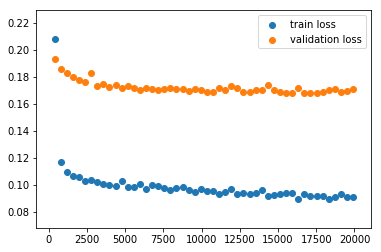

In [15]:
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

We transform the predicted validation values back to angles.

In [16]:
validation_preds_angles = [back_to_angle(i.detach().numpy()) for i in validation_preds]

Choose an arbitrary validation protein for further inspection.

In [17]:
test_protein = val_ids_remain[49]

In [18]:
test_angles_real = val_angles[49]
test_angles_pred = validation_preds_angles[49]

We'll start building structures from sequences and predicted angles. We'll save this as pdb files for visualization.
<br>
<br>
Note that since the PeptideBuilder tool is not super accurate we will compare the predicted structure with the reconstructed structure, i.e. the structure reconstructed from the real angles (instead of the actual original 3D coordinates), to better gauge performance.
<br>
<br>
We will use pymol for visualization.

In [19]:
def onehot_to_str(onehot_arr):
    '''Helper function to recover aa sequence from onehot encoding
        input must be aa*N numpy array'''
    aas = []
    N = onehot_arr.shape[1]
    for i in range(N):
        pos = np.where(onehot_arr[:, i]>0)[0]
        aas.append(pos_aa_dict[int(pos)])
    return "".join(aas)

In [20]:
test_protein_seq = onehot_to_str(val_seqs[49].numpy()[0, :,:])

In [21]:
def make_pb_structure(seq_str, angles):
    '''Construct 3D structure from angles and amino acid sequence'''
    psi = np.degrees(angles[0, :].tolist())
    omega = np.degrees(angles[1, :].tolist())
    phi = np.degrees(angles[2, :].tolist())
    structure = PeptideBuilder.make_structure(seq_str, phi, psi, omega)
    return(structure)

In [22]:
test_structure_real = make_pb_structure(test_protein_seq, test_angles_real[0, :, :])

In [23]:
test_structure_pred = make_pb_structure(test_protein_seq, test_angles_pred[0, :, :])

In [24]:
import Bio.PDB
def write_to_pdb(structure, prot_id, identifier):
    out = Bio.PDB.PDBIO()
    out.set_structure(structure)
    out.save(prot_id + identifier + ".pdb")

In [25]:
write_to_pdb(test_structure_real, test_protein, '_real_v8')
write_to_pdb(test_structure_pred, test_protein, '_pred_v8')

We can open the saved pdb files in pymol, align them and save the image. Cyan = predicted, green = true.

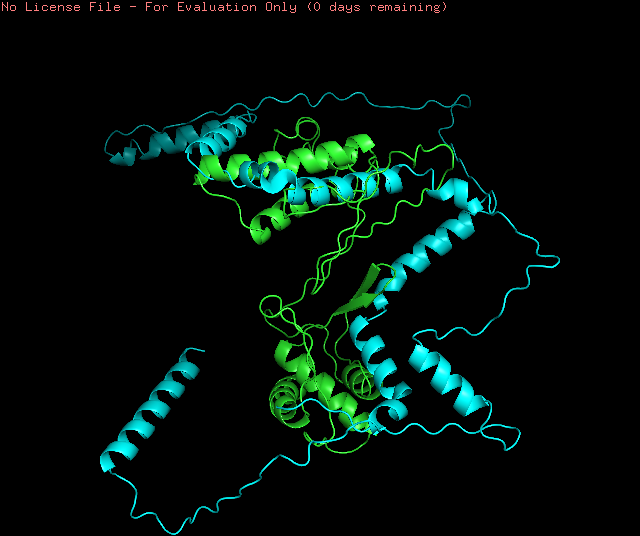

In [26]:
from IPython.display import Image 
im = Image(filename="/Users/Deathvoodoo/big_folders_docs/random/protein_alignment_v8.png")
display(im)

Not quite alphafold tier.
<br>
<br>
Checking distribution of real angles and predicted angles for the test protein.

In [27]:
print(test_angles_pred.shape)
print(test_angles_real.shape)

(1, 3, 242)
(1, 3, 242)


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


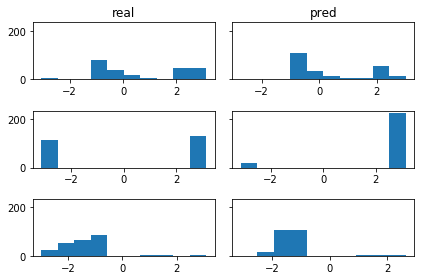

In [28]:
fig, axs = plt.subplots(3, 2, sharey=True, tight_layout=True)
#n_bins=20
labels = ['real', 'pred']
axs[0, 0].hist(test_angles_real[0, 0,:])
axs[0, 0].set_title('real')
axs[0, 1].hist(test_angles_pred[0, 0,:])
axs[0, 1].set_title('pred')
axs[1, 0].hist(test_angles_real[0, 1,:])
axs[1, 1].hist(test_angles_pred[0, 1,:])
axs[2, 0].hist(test_angles_real[0, 2,:])
axs[2, 1].hist(test_angles_pred[0, 2,:])
plt.show()

In [29]:
def make_coord_array(pdbstructure):
    '''turn coordinates into an array to calculate rmsd'''
    structure = pdbstructure
    model = structure[0]
    chain = model['A']

    atom_coords = []
    for atom in chain.get_atoms():
        backbone_atoms = ('N', 'CA', 'C')
        if atom.get_id() in backbone_atoms:
            atom_coords.append(atom.get_coord())
    atom_coords = np.array(atom_coords).T
    return atom_coords
    

In [30]:
test_structure_coords_pred = make_coord_array(test_structure_pred)
test_structure_coords_real = make_coord_array(test_structure_real)

Check RMSD between predicted and 'real' coordinates.

In [31]:
from numpy.linalg import svd, det
def rmsd_calculator(x, y):
    '''RMSD function from first year of master'''
    n = x.shape[1]
    centered_x = (x.T - np.mean(x, 1)).T # centering the coordinates
    centered_y = (y.T - np.mean(y, 1)).T
    R = centered_y @ centered_x.T
    V, S, WT = svd(R) # singular value decomposition
    U = WT.T@V.T
    Z = np.array([[1,0,0],[0,1,0],[0,0,-1]]) # matrix for reflection catch
    if det(U) < 0: # reflection catch
        U = WT.T @ Z @ V.T
        S[2] = -S[2]
    
    E_0 = np.sum(centered_x**2+centered_y**2)
    #rmsd = np.sqrt(1/n*(E_0 - 2*np.sum(S))) # both ways valid
    rmsd = np.sqrt(1/n*np.sum((centered_x-U@centered_y)**2))
    return(rmsd)


print(rmsd_calculator(test_structure_coords_real, test_structure_coords_pred))

33.15440254585553


Check RMSD between real coordinates and 'real' coordinates reconstructed from angles.

In [32]:
print(rmsd_calculator(val_coords[49], test_structure_coords_real))

1797.2509027557792


Judging by that latter RMSD something is weird. We can download the pdb file (1j2p) and inspect things a bit.

In [33]:
print(test_protein)
print(test_structure_coords_real.shape)
print(val_coords[49].shape)

90#1J2P_1_A
(3, 729)
(3, 729)


In [34]:
parser = Bio.PDB.PDBParser(QUIET=True)
test_protein_pdb = parser.get_structure(test_protein, '1j2p.pdb')

In [35]:
test_protein_atomic_coords = make_coord_array(test_protein_pdb) # coordinates from pdb file

In [36]:
val_coords[49][:, 0:10]

array([[4721.5, 4611. , 4661.3, 4766. , 4823.3, 4804.6, 4739.8, 4714.3,
        4848.1, 4845.4],
       [9562.2, 9468.1, 9358. , 9288.2, 9181.9, 9044.4, 8955.6, 8818.9,
        8758.2, 8662.1],
       [-546.8, -575. , -667.4, -624.9, -706.3, -643.7, -719.2, -673.9,
        -634.5, -543.4]])

In [37]:
test_protein_atomic_coords[:, 0:10] # different unit

array([[47.215, 46.11 , 46.613, 47.66 , 48.233, 48.046, 47.398, 47.143,
        48.481, 48.454],
       [95.622, 94.681, 93.58 , 92.882, 91.819, 90.444, 89.556, 88.189,
        87.582, 86.621],
       [-5.468, -5.75 , -6.674, -6.249, -7.063, -6.437, -7.192, -6.739,
        -6.345, -5.434]], dtype=float32)

Looks like the coordinates in the proteinnet file are multiplied with 100 for some reason.

In [38]:
rmsd_calculator(test_protein_atomic_coords, val_coords[49]*0.01) # ok looks better

6.551076390617608e-05

Let's check the difference between the protein built from angles and the real one. Note that the full 1j2p structure has 6 chains but since the proteinnet file only uses the A chain we just delete the other ones in pymol.

In [39]:
print(rmsd_calculator(val_coords[49]*0.01, test_structure_coords_real))

14.851347916737465


Cyan = built with peptide builder. Green = real.

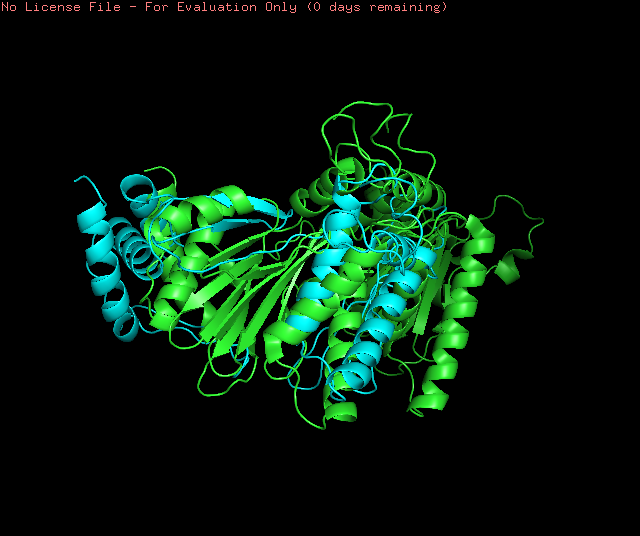

In [40]:
im = Image(filename="/Users/Deathvoodoo/big_folders_docs/random/1j2p_real_fromangles_aligned.png")
display(im)